### CNN applicato a serie dati multivariata di due celle

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 
from math import sqrt
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')

data = pd.read_csv('/Users/alket/Desktop/dati/new_data_backfill_forwfill.csv',index_col = 0)

# preparazione dati per due celle
agg_by_cell = data.groupby(by = ['cell_num'])
cell_1 = agg_by_cell.get_group('486-1252')
cell_2 = agg_by_cell.get_group('486-1256')
cell_3 = agg_by_cell.get_group('486-1258')
# define input sequence
series1 = cell_1['nr_people'].values
series2 = cell_2['nr_people'].values
series3 = cell_3['nr_people'].values
print(type(series2))

<class 'numpy.ndarray'>


In [3]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# define input sequence
out_seq = np.array([series1[i]+series2[i]+series3[i] for i in range(len(series1))])

# convert to [rows, columns] structure
series1 = series1.reshape((len(series1), 1))
series2 = series2.reshape((len(series2), 1))
series3 = series3.reshape((len(series3), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = hstack((series1, series2, series3, out_seq))

# choose a number of time steps
n_steps = 4

# convert into input/output
X, y = split_sequences(dataset, n_steps)
for i in range(len(X)):
    print(X[i], y[i])
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

[[ 36.  43.  42. 121.]
 [ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]] [ 32.  37.  37. 106.]
[[ 36.  43.  42. 121.]
 [ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]] [ 33.  37.  37. 107.]
[[ 34.  40.  40. 114.]
 [ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]] [ 32.  36.  35. 103.]
[[ 33.  39.  39. 111.]
 [ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]] [30. 34. 34. 98.]
[[ 32.  37.  37. 106.]
 [ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]] [30. 34. 33. 97.]
[[ 33.  37.  37. 107.]
 [ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]] [29. 33. 32. 94.]
[[ 32.  36.  35. 103.]
 [ 30.  34.  34.  98.]
 [ 30.  34.  33.  97.]
 [ 29.  33.  32.  94.]] [29. 32. 31. 92.]
[[30. 34. 34. 98.]
 [30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [29. 32. 31. 92.]] [27. 30. 29. 86.]
[[30. 34. 33. 97.]
 [29. 33. 32. 94.]
 [29. 32. 31. 92.]
 [27. 30. 29. 86.]] [27. 30. 29. 86.]
[[29. 33. 32. 94.]
 [

 [24. 27. 29. 80.]] [23. 26. 28. 77.]
[[24. 28. 30. 82.]
 [24. 27. 29. 80.]
 [24. 27. 29. 80.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[24. 27. 29. 80.]
 [24. 27. 29. 80.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[24. 27. 29. 80.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [23. 26. 28. 77.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]] [21. 24. 29. 74.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [21. 24. 29. 74.]] [21. 24. 29. 74.]
[[23. 26. 28. 77.]
 [23. 26. 28. 77.]
 [21. 24. 29. 74.]
 [21. 24. 29. 74.]] [21. 24. 29. 74.]
[[23. 26. 28. 77.]
 [21. 24. 29. 74.]
 [21. 24. 29. 74.]
 [21. 24. 29. 74.]] [23. 26. 28. 77.]
[[21. 24. 29. 74.]
 [21. 24. 29. 74.]
 [21. 24. 29. 74.]
 [23. 26. 28. 77.]] [23. 26. 27. 76.]
[[21. 24. 29. 74.]
 [21. 24. 29. 74.]
 [23. 26. 28. 77.]
 [23. 26. 27. 76.]] [23. 26. 28. 77.]
[[21. 24. 29

 [ 39.  44.  49. 132.]] [ 40.  46.  50. 136.]
[[ 38.  44.  47. 129.]
 [ 39.  45.  47. 131.]
 [ 39.  44.  49. 132.]
 [ 40.  46.  50. 136.]] [ 40.  46.  50. 136.]
[[ 39.  45.  47. 131.]
 [ 39.  44.  49. 132.]
 [ 40.  46.  50. 136.]
 [ 40.  46.  50. 136.]] [ 40.  45.  49. 134.]
[[ 39.  44.  49. 132.]
 [ 40.  46.  50. 136.]
 [ 40.  46.  50. 136.]
 [ 40.  45.  49. 134.]] [ 38.  42.  45. 125.]
[[ 40.  46.  50. 136.]
 [ 40.  46.  50. 136.]
 [ 40.  45.  49. 134.]
 [ 38.  42.  45. 125.]] [ 36.  41.  43. 120.]
[[ 40.  46.  50. 136.]
 [ 40.  45.  49. 134.]
 [ 38.  42.  45. 125.]
 [ 36.  41.  43. 120.]] [ 36.  41.  43. 120.]
[[ 40.  45.  49. 134.]
 [ 38.  42.  45. 125.]
 [ 36.  41.  43. 120.]
 [ 36.  41.  43. 120.]] [ 34.  38.  40. 112.]
[[ 38.  42.  45. 125.]
 [ 36.  41.  43. 120.]
 [ 36.  41.  43. 120.]
 [ 34.  38.  40. 112.]] [ 34.  38.  40. 112.]
[[ 36.  41.  43. 120.]
 [ 36.  41.  43. 120.]
 [ 34.  38.  40. 112.]
 [ 34.  38.  40. 112.]] [ 32.  36.  38. 106.]
[[ 36.  41.  43. 120.]
 [ 34.  38.

 [25. 28. 29. 82.]] [25. 28. 28. 81.]
[[27. 30. 30. 87.]
 [26. 29. 29. 84.]
 [25. 28. 29. 82.]
 [25. 28. 28. 81.]] [25. 27. 28. 80.]
[[26. 29. 29. 84.]
 [25. 28. 29. 82.]
 [25. 28. 28. 81.]
 [25. 27. 28. 80.]] [24. 27. 27. 78.]
[[25. 28. 29. 82.]
 [25. 28. 28. 81.]
 [25. 27. 28. 80.]
 [24. 27. 27. 78.]] [23. 26. 27. 76.]
[[25. 28. 28. 81.]
 [25. 27. 28. 80.]
 [24. 27. 27. 78.]
 [23. 26. 27. 76.]] [22. 25. 27. 74.]
[[25. 27. 28. 80.]
 [24. 27. 27. 78.]
 [23. 26. 27. 76.]
 [22. 25. 27. 74.]] [22. 24. 27. 73.]
[[24. 27. 27. 78.]
 [23. 26. 27. 76.]
 [22. 25. 27. 74.]
 [22. 24. 27. 73.]] [22. 25. 28. 75.]
[[23. 26. 27. 76.]
 [22. 25. 27. 74.]
 [22. 24. 27. 73.]
 [22. 25. 28. 75.]] [22. 25. 29. 76.]
[[22. 25. 27. 74.]
 [22. 24. 27. 73.]
 [22. 25. 28. 75.]
 [22. 25. 29. 76.]] [22. 25. 29. 76.]
[[22. 24. 27. 73.]
 [22. 25. 28. 75.]
 [22. 25. 29. 76.]
 [22. 25. 29. 76.]] [23. 26. 29. 78.]
[[22. 25. 28. 75.]
 [22. 25. 29. 76.]
 [22. 25. 29. 76.]
 [23. 26. 29. 78.]] [24. 26. 28. 78.]
[[22. 25. 29

 [24. 26. 27. 77.]] [25. 28. 29. 82.]
[[25. 27. 27. 79.]
 [24. 27. 27. 78.]
 [24. 26. 27. 77.]
 [25. 28. 29. 82.]] [27. 30. 32. 89.]
[[24. 27. 27. 78.]
 [24. 26. 27. 77.]
 [25. 28. 29. 82.]
 [27. 30. 32. 89.]] [28. 31. 33. 92.]
[[24. 26. 27. 77.]
 [25. 28. 29. 82.]
 [27. 30. 32. 89.]
 [28. 31. 33. 92.]] [28. 32. 36. 96.]
[[25. 28. 29. 82.]
 [27. 30. 32. 89.]
 [28. 31. 33. 92.]
 [28. 32. 36. 96.]] [28. 32. 36. 96.]
[[27. 30. 32. 89.]
 [28. 31. 33. 92.]
 [28. 32. 36. 96.]
 [28. 32. 36. 96.]] [ 33.  37.  40. 110.]
[[ 28.  31.  33.  92.]
 [ 28.  32.  36.  96.]
 [ 28.  32.  36.  96.]
 [ 33.  37.  40. 110.]] [ 35.  39.  41. 115.]
[[ 28.  32.  36.  96.]
 [ 28.  32.  36.  96.]
 [ 33.  37.  40. 110.]
 [ 35.  39.  41. 115.]] [ 37.  41.  44. 122.]
[[ 28.  32.  36.  96.]
 [ 33.  37.  40. 110.]
 [ 35.  39.  41. 115.]
 [ 37.  41.  44. 122.]] [ 40.  44.  45. 129.]
[[ 33.  37.  40. 110.]
 [ 35.  39.  41. 115.]
 [ 37.  41.  44. 122.]
 [ 40.  44.  45. 129.]] [ 39.  44.  46. 129.]
[[ 35.  39.  41. 115.]


 [25. 28. 30. 83.]] [25. 28. 29. 82.]
[[26. 29. 30. 85.]
 [26. 29. 31. 86.]
 [25. 28. 30. 83.]
 [25. 28. 29. 82.]] [24. 27. 28. 79.]
[[26. 29. 31. 86.]
 [25. 28. 30. 83.]
 [25. 28. 29. 82.]
 [24. 27. 28. 79.]] [24. 27. 28. 79.]
[[25. 28. 30. 83.]
 [25. 28. 29. 82.]
 [24. 27. 28. 79.]
 [24. 27. 28. 79.]] [25. 28. 28. 81.]
[[25. 28. 29. 82.]
 [24. 27. 28. 79.]
 [24. 27. 28. 79.]
 [25. 28. 28. 81.]] [25. 28. 28. 81.]
[[24. 27. 28. 79.]
 [24. 27. 28. 79.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]] [25. 28. 28. 81.]
[[24. 27. 28. 79.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]] [28. 31. 34. 93.]
[[25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [28. 31. 34. 93.]] [28. 31. 35. 94.]
[[25. 28. 28. 81.]
 [25. 28. 28. 81.]
 [28. 31. 34. 93.]
 [28. 31. 35. 94.]] [28. 32. 35. 95.]
[[25. 28. 28. 81.]
 [28. 31. 34. 93.]
 [28. 31. 35. 94.]
 [28. 32. 35. 95.]] [ 31.  34.  36. 101.]
[[ 28.  31.  34.  93.]
 [ 28.  31.  35.  94.]
 [ 28.  32.  35.  95.]
 [ 31.  34.  36. 101.]] [ 31.  35.

 [ 33.  37.  35. 105.]] [31. 35. 33. 99.]
[[ 36.  41.  39. 116.]
 [ 33.  37.  35. 105.]
 [ 33.  37.  35. 105.]
 [ 31.  35.  33.  99.]] [30. 34. 33. 97.]
[[ 33.  37.  35. 105.]
 [ 33.  37.  35. 105.]
 [ 31.  35.  33.  99.]
 [ 30.  34.  33.  97.]] [30. 34. 33. 97.]
[[ 33.  37.  35. 105.]
 [ 31.  35.  33.  99.]
 [ 30.  34.  33.  97.]
 [ 30.  34.  33.  97.]] [30. 34. 33. 97.]
[[31. 35. 33. 99.]
 [30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [30. 34. 33. 97.]] [30. 34. 33. 97.]
[[30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [30. 34. 33. 97.]] [26. 29. 28. 83.]
[[30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [26. 29. 28. 83.]] [25. 29. 28. 82.]
[[30. 34. 33. 97.]
 [30. 34. 33. 97.]
 [26. 29. 28. 83.]
 [25. 29. 28. 82.]] [25. 29. 28. 82.]
[[30. 34. 33. 97.]
 [26. 29. 28. 83.]
 [25. 29. 28. 82.]
 [25. 29. 28. 82.]] [25. 29. 28. 82.]
[[26. 29. 28. 83.]
 [25. 29. 28. 82.]
 [25. 29. 28. 82.]
 [25. 29. 28. 82.]] [25. 29. 28. 82.]
[[25. 29. 28. 82.]
 [25. 29. 28. 82.]
 [25. 29. 28. 82.

 [ 45.  50.  48. 143.]] [ 43.  48.  48. 139.]
[[ 45.  50.  48. 143.]
 [ 45.  50.  48. 143.]
 [ 45.  50.  48. 143.]
 [ 43.  48.  48. 139.]] [ 43.  48.  46. 137.]
[[ 45.  50.  48. 143.]
 [ 45.  50.  48. 143.]
 [ 43.  48.  48. 139.]
 [ 43.  48.  46. 137.]] [ 42.  46.  44. 132.]
[[ 45.  50.  48. 143.]
 [ 43.  48.  48. 139.]
 [ 43.  48.  46. 137.]
 [ 42.  46.  44. 132.]] [ 40.  44.  43. 127.]
[[ 43.  48.  48. 139.]
 [ 43.  48.  46. 137.]
 [ 42.  46.  44. 132.]
 [ 40.  44.  43. 127.]] [ 40.  44.  43. 127.]
[[ 43.  48.  46. 137.]
 [ 42.  46.  44. 132.]
 [ 40.  44.  43. 127.]
 [ 40.  44.  43. 127.]] [ 37.  41.  39. 117.]
[[ 42.  46.  44. 132.]
 [ 40.  44.  43. 127.]
 [ 40.  44.  43. 127.]
 [ 37.  41.  39. 117.]] [ 37.  40.  38. 115.]
[[ 40.  44.  43. 127.]
 [ 40.  44.  43. 127.]
 [ 37.  41.  39. 117.]
 [ 37.  40.  38. 115.]] [ 35.  39.  37. 111.]
[[ 40.  44.  43. 127.]
 [ 37.  41.  39. 117.]
 [ 37.  40.  38. 115.]
 [ 35.  39.  37. 111.]] [ 35.  39.  37. 111.]
[[ 37.  41.  39. 117.]
 [ 37.  40.

 [ 52.  58.  53. 163.]] [ 52.  57.  52. 161.]
[[ 54.  60.  56. 170.]
 [ 53.  59.  54. 166.]
 [ 52.  58.  53. 163.]
 [ 52.  57.  52. 161.]] [ 52.  58.  53. 163.]
[[ 53.  59.  54. 166.]
 [ 52.  58.  53. 163.]
 [ 52.  57.  52. 161.]
 [ 52.  58.  53. 163.]] [ 50.  56.  52. 158.]
[[ 52.  58.  53. 163.]
 [ 52.  57.  52. 161.]
 [ 52.  58.  53. 163.]
 [ 50.  56.  52. 158.]] [ 49.  54.  50. 153.]
[[ 52.  57.  52. 161.]
 [ 52.  58.  53. 163.]
 [ 50.  56.  52. 158.]
 [ 49.  54.  50. 153.]] [ 49.  54.  50. 153.]
[[ 52.  58.  53. 163.]
 [ 50.  56.  52. 158.]
 [ 49.  54.  50. 153.]
 [ 49.  54.  50. 153.]] [ 47.  52.  49. 148.]
[[ 50.  56.  52. 158.]
 [ 49.  54.  50. 153.]
 [ 49.  54.  50. 153.]
 [ 47.  52.  49. 148.]] [ 46.  51.  48. 145.]
[[ 49.  54.  50. 153.]
 [ 49.  54.  50. 153.]
 [ 47.  52.  49. 148.]
 [ 46.  51.  48. 145.]] [ 45.  50.  47. 142.]
[[ 49.  54.  50. 153.]
 [ 47.  52.  49. 148.]
 [ 46.  51.  48. 145.]
 [ 45.  50.  47. 142.]] [ 46.  50.  47. 143.]
[[ 47.  52.  49. 148.]
 [ 46.  51.

 [ 56.  63.  60. 179.]] [ 56.  63.  59. 178.]
[[ 52.  59.  57. 168.]
 [ 53.  60.  58. 171.]
 [ 56.  63.  60. 179.]
 [ 56.  63.  59. 178.]] [ 54.  61.  59. 174.]
[[ 53.  60.  58. 171.]
 [ 56.  63.  60. 179.]
 [ 56.  63.  59. 178.]
 [ 54.  61.  59. 174.]] [ 53.  61.  58. 172.]
[[ 56.  63.  60. 179.]
 [ 56.  63.  59. 178.]
 [ 54.  61.  59. 174.]
 [ 53.  61.  58. 172.]] [ 55.  62.  60. 177.]
[[ 56.  63.  59. 178.]
 [ 54.  61.  59. 174.]
 [ 53.  61.  58. 172.]
 [ 55.  62.  60. 177.]] [ 55.  62.  61. 178.]
[[ 54.  61.  59. 174.]
 [ 53.  61.  58. 172.]
 [ 55.  62.  60. 177.]
 [ 55.  62.  61. 178.]] [ 55.  62.  62. 179.]
[[ 53.  61.  58. 172.]
 [ 55.  62.  60. 177.]
 [ 55.  62.  61. 178.]
 [ 55.  62.  62. 179.]] [ 55.  62.  62. 179.]
[[ 55.  62.  60. 177.]
 [ 55.  62.  61. 178.]
 [ 55.  62.  62. 179.]
 [ 55.  62.  62. 179.]] [ 55.  61.  59. 175.]
[[ 55.  62.  61. 178.]
 [ 55.  62.  62. 179.]
 [ 55.  62.  62. 179.]
 [ 55.  61.  59. 175.]] [ 56.  62.  59. 177.]
[[ 55.  62.  62. 179.]
 [ 55.  62.

 [ 73.  77.  62. 212.]] [ 73.  78.  63. 214.]
[[ 72.  76.  60. 208.]
 [ 73.  77.  61. 211.]
 [ 73.  77.  62. 212.]
 [ 73.  78.  63. 214.]] [ 75.  79.  65. 219.]
[[ 73.  77.  61. 211.]
 [ 73.  77.  62. 212.]
 [ 73.  78.  63. 214.]
 [ 75.  79.  65. 219.]] [ 77.  82.  66. 225.]
[[ 73.  77.  62. 212.]
 [ 73.  78.  63. 214.]
 [ 75.  79.  65. 219.]
 [ 77.  82.  66. 225.]] [ 77.  82.  65. 224.]
[[ 73.  78.  63. 214.]
 [ 75.  79.  65. 219.]
 [ 77.  82.  66. 225.]
 [ 77.  82.  65. 224.]] [ 78.  83.  67. 228.]
[[ 75.  79.  65. 219.]
 [ 77.  82.  66. 225.]
 [ 77.  82.  65. 224.]
 [ 78.  83.  67. 228.]] [ 79.  84.  67. 230.]
[[ 77.  82.  66. 225.]
 [ 77.  82.  65. 224.]
 [ 78.  83.  67. 228.]
 [ 79.  84.  67. 230.]] [ 80.  84.  68. 232.]
[[ 77.  82.  65. 224.]
 [ 78.  83.  67. 228.]
 [ 79.  84.  67. 230.]
 [ 80.  84.  68. 232.]] [ 80.  84.  68. 232.]
[[ 78.  83.  67. 228.]
 [ 79.  84.  67. 230.]
 [ 80.  84.  68. 232.]
 [ 80.  84.  68. 232.]] [ 81.  86.  71. 238.]
[[ 79.  84.  67. 230.]
 [ 80.  84.

 [ 46.  51.  46. 143.]] [ 46.  51.  48. 145.]
[[ 40.  45.  41. 126.]
 [ 44.  49.  43. 136.]
 [ 46.  51.  46. 143.]
 [ 46.  51.  48. 145.]] [ 46.  52.  47. 145.]
[[ 44.  49.  43. 136.]
 [ 46.  51.  46. 143.]
 [ 46.  51.  48. 145.]
 [ 46.  52.  47. 145.]] [ 46.  52.  47. 145.]
[[ 46.  51.  46. 143.]
 [ 46.  51.  48. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]] [ 46.  52.  47. 145.]
[[ 46.  51.  48. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]] [ 46.  52.  47. 145.]
[[ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]] [ 46.  52.  47. 145.]
[[ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]] [ 46.  52.  47. 145.]
[[ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]] [ 50.  57.  51. 158.]
[[ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 46.  52.  47. 145.]
 [ 50.  57.  51. 158.]] [ 52.  59.  52. 163.]
[[ 46.  52.  47. 145.]
 [ 46.  52.

 [31. 34. 31. 96.]] [ 33.  36.  32. 101.]
[[ 30.  33.  29.  92.]
 [ 31.  34.  30.  95.]
 [ 31.  34.  31.  96.]
 [ 33.  36.  32. 101.]] [ 35.  39.  34. 108.]
[[ 31.  34.  30.  95.]
 [ 31.  34.  31.  96.]
 [ 33.  36.  32. 101.]
 [ 35.  39.  34. 108.]] [ 38.  42.  36. 116.]
[[ 31.  34.  31.  96.]
 [ 33.  36.  32. 101.]
 [ 35.  39.  34. 108.]
 [ 38.  42.  36. 116.]] [ 41.  46.  39. 126.]
[[ 33.  36.  32. 101.]
 [ 35.  39.  34. 108.]
 [ 38.  42.  36. 116.]
 [ 41.  46.  39. 126.]] [ 41.  46.  39. 126.]
[[ 35.  39.  34. 108.]
 [ 38.  42.  36. 116.]
 [ 41.  46.  39. 126.]
 [ 41.  46.  39. 126.]] [ 47.  51.  43. 141.]
[[ 38.  42.  36. 116.]
 [ 41.  46.  39. 126.]
 [ 41.  46.  39. 126.]
 [ 47.  51.  43. 141.]] [ 44.  49.  44. 137.]
[[ 41.  46.  39. 126.]
 [ 41.  46.  39. 126.]
 [ 47.  51.  43. 141.]
 [ 44.  49.  44. 137.]] [ 45.  49.  45. 139.]
[[ 41.  46.  39. 126.]
 [ 47.  51.  43. 141.]
 [ 44.  49.  44. 137.]
 [ 45.  49.  45. 139.]] [ 45.  49.  45. 139.]
[[ 47.  51.  43. 141.]
 [ 44.  49.  44

 [27. 29. 27. 83.]] [27. 29. 27. 83.]
[[26. 29. 26. 81.]
 [26. 28. 26. 80.]
 [27. 29. 27. 83.]
 [27. 29. 27. 83.]] [28. 31. 28. 87.]
[[26. 28. 26. 80.]
 [27. 29. 27. 83.]
 [27. 29. 27. 83.]
 [28. 31. 28. 87.]] [29. 32. 27. 88.]
[[27. 29. 27. 83.]
 [27. 29. 27. 83.]
 [28. 31. 28. 87.]
 [29. 32. 27. 88.]] [30. 32. 27. 89.]
[[27. 29. 27. 83.]
 [28. 31. 28. 87.]
 [29. 32. 27. 88.]
 [30. 32. 27. 89.]] [31. 33. 27. 91.]
[[28. 31. 28. 87.]
 [29. 32. 27. 88.]
 [30. 32. 27. 89.]
 [31. 33. 27. 91.]] [31. 33. 27. 91.]
[[29. 32. 27. 88.]
 [30. 32. 27. 89.]
 [31. 33. 27. 91.]
 [31. 33. 27. 91.]] [31. 34. 27. 92.]
[[30. 32. 27. 89.]
 [31. 33. 27. 91.]
 [31. 33. 27. 91.]
 [31. 34. 27. 92.]] [30. 33. 27. 90.]
[[31. 33. 27. 91.]
 [31. 33. 27. 91.]
 [31. 34. 27. 92.]
 [30. 33. 27. 90.]] [29. 32. 27. 88.]
[[31. 33. 27. 91.]
 [31. 34. 27. 92.]
 [30. 33. 27. 90.]
 [29. 32. 27. 88.]] [31. 34. 28. 93.]
[[31. 34. 27. 92.]
 [30. 33. 27. 90.]
 [29. 32. 27. 88.]
 [31. 34. 28. 93.]] [32. 36. 29. 97.]
[[30. 33. 27

 [30. 33. 29. 92.]] [30. 33. 29. 92.]
[[31. 34. 30. 95.]
 [30. 33. 30. 93.]
 [30. 33. 29. 92.]
 [30. 33. 29. 92.]] [29. 32. 28. 89.]
[[30. 33. 30. 93.]
 [30. 33. 29. 92.]
 [30. 33. 29. 92.]
 [29. 32. 28. 89.]] [30. 33. 27. 90.]
[[30. 33. 29. 92.]
 [30. 33. 29. 92.]
 [29. 32. 28. 89.]
 [30. 33. 27. 90.]] [30. 33. 27. 90.]
[[30. 33. 29. 92.]
 [29. 32. 28. 89.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]] [29. 32. 28. 89.]
[[29. 32. 28. 89.]
 [30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [29. 32. 28. 89.]] [29. 32. 28. 89.]
[[30. 33. 27. 90.]
 [30. 33. 27. 90.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]] [29. 32. 29. 90.]
[[30. 33. 27. 90.]
 [29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [29. 32. 29. 90.]] [31. 34. 29. 94.]
[[29. 32. 28. 89.]
 [29. 32. 28. 89.]
 [29. 32. 29. 90.]
 [31. 34. 29. 94.]] [31. 34. 29. 94.]
[[29. 32. 28. 89.]
 [29. 32. 29. 90.]
 [31. 34. 29. 94.]
 [31. 34. 29. 94.]] [31. 34. 27. 92.]
[[29. 32. 29. 90.]
 [31. 34. 29. 94.]
 [31. 34. 29. 94.]
 [31. 34. 27. 92.]] [32. 35. 27. 94.]
[[31. 34. 29

 [ 45.  50.  45. 140.]] [ 43.  47.  44. 134.]
[[ 49.  55.  49. 153.]
 [ 46.  51.  47. 144.]
 [ 45.  50.  45. 140.]
 [ 43.  47.  44. 134.]] [ 41.  46.  42. 129.]
[[ 46.  51.  47. 144.]
 [ 45.  50.  45. 140.]
 [ 43.  47.  44. 134.]
 [ 41.  46.  42. 129.]] [ 39.  43.  41. 123.]
[[ 45.  50.  45. 140.]
 [ 43.  47.  44. 134.]
 [ 41.  46.  42. 129.]
 [ 39.  43.  41. 123.]] [ 39.  43.  41. 123.]
[[ 43.  47.  44. 134.]
 [ 41.  46.  42. 129.]
 [ 39.  43.  41. 123.]
 [ 39.  43.  41. 123.]] [ 38.  42.  40. 120.]
[[ 41.  46.  42. 129.]
 [ 39.  43.  41. 123.]
 [ 39.  43.  41. 123.]
 [ 38.  42.  40. 120.]] [ 36.  40.  38. 114.]
[[ 39.  43.  41. 123.]
 [ 39.  43.  41. 123.]
 [ 38.  42.  40. 120.]
 [ 36.  40.  38. 114.]] [ 36.  40.  38. 114.]
[[ 39.  43.  41. 123.]
 [ 38.  42.  40. 120.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]] [ 34.  38.  35. 107.]
[[ 38.  42.  40. 120.]
 [ 36.  40.  38. 114.]
 [ 36.  40.  38. 114.]
 [ 34.  38.  35. 107.]] [ 33.  37.  34. 104.]
[[ 36.  40.  38. 114.]
 [ 36.  40.

 [ 43.  48.  37. 128.]] [ 42.  47.  37. 126.]
[[ 49.  55.  44. 148.]
 [ 45.  51.  40. 136.]
 [ 43.  48.  37. 128.]
 [ 42.  47.  37. 126.]] [ 40.  45.  35. 120.]
[[ 45.  51.  40. 136.]
 [ 43.  48.  37. 128.]
 [ 42.  47.  37. 126.]
 [ 40.  45.  35. 120.]] [ 39.  44.  35. 118.]
[[ 43.  48.  37. 128.]
 [ 42.  47.  37. 126.]
 [ 40.  45.  35. 120.]
 [ 39.  44.  35. 118.]] [ 39.  44.  35. 118.]
[[ 42.  47.  37. 126.]
 [ 40.  45.  35. 120.]
 [ 39.  44.  35. 118.]
 [ 39.  44.  35. 118.]] [ 37.  42.  33. 112.]
[[ 40.  45.  35. 120.]
 [ 39.  44.  35. 118.]
 [ 39.  44.  35. 118.]
 [ 37.  42.  33. 112.]] [ 36.  41.  33. 110.]
[[ 39.  44.  35. 118.]
 [ 39.  44.  35. 118.]
 [ 37.  42.  33. 112.]
 [ 36.  41.  33. 110.]] [ 36.  41.  33. 110.]
[[ 39.  44.  35. 118.]
 [ 37.  42.  33. 112.]
 [ 36.  41.  33. 110.]
 [ 36.  41.  33. 110.]] [ 34.  38.  31. 103.]
[[ 37.  42.  33. 112.]
 [ 36.  41.  33. 110.]
 [ 36.  41.  33. 110.]
 [ 34.  38.  31. 103.]] [ 34.  38.  31. 103.]
[[ 36.  41.  33. 110.]
 [ 36.  41.

 [ 67.  79.  42. 188.]] [ 64.  75.  39. 178.]
[[ 65.  78.  42. 185.]
 [ 65.  78.  42. 185.]
 [ 67.  79.  42. 188.]
 [ 64.  75.  39. 178.]] [ 61.  72.  37. 170.]
[[ 65.  78.  42. 185.]
 [ 67.  79.  42. 188.]
 [ 64.  75.  39. 178.]
 [ 61.  72.  37. 170.]] [ 60.  71.  36. 167.]
[[ 67.  79.  42. 188.]
 [ 64.  75.  39. 178.]
 [ 61.  72.  37. 170.]
 [ 60.  71.  36. 167.]] [ 58.  69.  35. 162.]
[[ 64.  75.  39. 178.]
 [ 61.  72.  37. 170.]
 [ 60.  71.  36. 167.]
 [ 58.  69.  35. 162.]] [ 58.  69.  35. 162.]
[[ 61.  72.  37. 170.]
 [ 60.  71.  36. 167.]
 [ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]] [ 58.  69.  35. 162.]
[[ 60.  71.  36. 167.]
 [ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]] [ 58.  69.  35. 162.]
[[ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]] [ 53.  63.  32. 148.]
[[ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]
 [ 58.  69.  35. 162.]
 [ 53.  63.  32. 148.]] [ 53.  63.  32. 148.]
[[ 58.  69.  35. 162.]
 [ 58.  69.

 [ 64.  77.  51. 192.]] [ 62.  76.  50. 188.]
[[ 64.  77.  51. 192.]
 [ 64.  77.  51. 192.]
 [ 64.  77.  51. 192.]
 [ 62.  76.  50. 188.]] [ 62.  76.  50. 188.]
[[ 64.  77.  51. 192.]
 [ 64.  77.  51. 192.]
 [ 62.  76.  50. 188.]
 [ 62.  76.  50. 188.]] [ 62.  75.  51. 188.]
[[ 64.  77.  51. 192.]
 [ 62.  76.  50. 188.]
 [ 62.  76.  50. 188.]
 [ 62.  75.  51. 188.]] [ 64.  75.  50. 189.]
[[ 62.  76.  50. 188.]
 [ 62.  76.  50. 188.]
 [ 62.  75.  51. 188.]
 [ 64.  75.  50. 189.]] [ 65.  75.  49. 189.]
[[ 62.  76.  50. 188.]
 [ 62.  75.  51. 188.]
 [ 64.  75.  50. 189.]
 [ 65.  75.  49. 189.]] [ 67.  76.  47. 190.]
[[ 62.  75.  51. 188.]
 [ 64.  75.  50. 189.]
 [ 65.  75.  49. 189.]
 [ 67.  76.  47. 190.]] [ 67.  76.  47. 190.]
[[ 64.  75.  50. 189.]
 [ 65.  75.  49. 189.]
 [ 67.  76.  47. 190.]
 [ 67.  76.  47. 190.]] [ 64.  73.  45. 182.]
[[ 65.  75.  49. 189.]
 [ 67.  76.  47. 190.]
 [ 67.  76.  47. 190.]
 [ 64.  73.  45. 182.]] [ 64.  73.  44. 181.]
[[ 67.  76.  47. 190.]
 [ 67.  76.

 [ 61.  79.  58. 198.]] [ 61.  79.  58. 198.]
[[ 62.  80.  60. 202.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]] [ 61.  79.  58. 198.]
[[ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]] [ 61.  79.  58. 198.]
[[ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]] [ 61.  79.  58. 198.]
[[ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]] [ 59.  74.  59. 192.]
[[ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 59.  74.  59. 192.]] [ 58.  73.  57. 188.]
[[ 61.  79.  58. 198.]
 [ 61.  79.  58. 198.]
 [ 59.  74.  59. 192.]
 [ 58.  73.  57. 188.]] [ 57.  73.  56. 186.]
[[ 61.  79.  58. 198.]
 [ 59.  74.  59. 192.]
 [ 58.  73.  57. 188.]
 [ 57.  73.  56. 186.]] [ 57.  73.  56. 186.]
[[ 59.  74.  59. 192.]
 [ 58.  73.  57. 188.]
 [ 57.  73.  56. 186.]
 [ 57.  73.  56. 186.]] [ 57.  71.  54. 182.]
[[ 58.  73.  57. 188.]
 [ 57.  73.

 [ 69.  92.  52. 213.]] [ 69.  92.  52. 213.]
[[ 67.  90.  51. 208.]
 [ 68.  92.  52. 212.]
 [ 69.  92.  52. 213.]
 [ 69.  92.  52. 213.]] [ 73.  98.  54. 225.]
[[ 68.  92.  52. 212.]
 [ 69.  92.  52. 213.]
 [ 69.  92.  52. 213.]
 [ 73.  98.  54. 225.]] [ 72.  99.  55. 226.]
[[ 69.  92.  52. 213.]
 [ 69.  92.  52. 213.]
 [ 73.  98.  54. 225.]
 [ 72.  99.  55. 226.]] [ 70.  97.  55. 222.]
[[ 69.  92.  52. 213.]
 [ 73.  98.  54. 225.]
 [ 72.  99.  55. 226.]
 [ 70.  97.  55. 222.]] [ 68.  94.  54. 216.]
[[ 73.  98.  54. 225.]
 [ 72.  99.  55. 226.]
 [ 70.  97.  55. 222.]
 [ 68.  94.  54. 216.]] [ 67.  93.  55. 215.]
[[ 72.  99.  55. 226.]
 [ 70.  97.  55. 222.]
 [ 68.  94.  54. 216.]
 [ 67.  93.  55. 215.]] [ 67.  93.  55. 215.]
[[ 70.  97.  55. 222.]
 [ 68.  94.  54. 216.]
 [ 67.  93.  55. 215.]
 [ 67.  93.  55. 215.]] [ 66.  91.  55. 212.]
[[ 68.  94.  54. 216.]
 [ 67.  93.  55. 215.]
 [ 67.  93.  55. 215.]
 [ 66.  91.  55. 212.]] [ 65.  89.  54. 208.]
[[ 67.  93.  55. 215.]
 [ 67.  93.

 [ 53.  67.  48. 168.]] [ 54.  68.  50. 172.]
[[ 51.  65.  45. 161.]
 [ 51.  65.  45. 161.]
 [ 53.  67.  48. 168.]
 [ 54.  68.  50. 172.]] [ 54.  68.  50. 172.]
[[ 51.  65.  45. 161.]
 [ 53.  67.  48. 168.]
 [ 54.  68.  50. 172.]
 [ 54.  68.  50. 172.]] [ 54.  68.  50. 172.]
[[ 53.  67.  48. 168.]
 [ 54.  68.  50. 172.]
 [ 54.  68.  50. 172.]
 [ 54.  68.  50. 172.]] [ 58.  74.  52. 184.]
[[ 54.  68.  50. 172.]
 [ 54.  68.  50. 172.]
 [ 54.  68.  50. 172.]
 [ 58.  74.  52. 184.]] [ 60.  75.  52. 187.]
[[ 54.  68.  50. 172.]
 [ 54.  68.  50. 172.]
 [ 58.  74.  52. 184.]
 [ 60.  75.  52. 187.]] [ 60.  76.  51. 187.]
[[ 54.  68.  50. 172.]
 [ 58.  74.  52. 184.]
 [ 60.  75.  52. 187.]
 [ 60.  76.  51. 187.]] [ 60.  76.  51. 187.]
[[ 58.  74.  52. 184.]
 [ 60.  75.  52. 187.]
 [ 60.  76.  51. 187.]
 [ 60.  76.  51. 187.]] [ 60.  76.  51. 187.]
[[ 60.  75.  52. 187.]
 [ 60.  76.  51. 187.]
 [ 60.  76.  51. 187.]
 [ 60.  76.  51. 187.]] [ 65.  81.  52. 198.]
[[ 60.  76.  51. 187.]
 [ 60.  76.

 [28. 33. 31. 92.]] [ 31.  39.  32. 102.]
[[ 27.  34.  29.  90.]
 [ 28.  33.  31.  92.]
 [ 28.  33.  31.  92.]
 [ 31.  39.  32. 102.]] [ 32.  40.  33. 105.]
[[ 28.  33.  31.  92.]
 [ 28.  33.  31.  92.]
 [ 31.  39.  32. 102.]
 [ 32.  40.  33. 105.]] [ 34.  43.  34. 111.]
[[ 28.  33.  31.  92.]
 [ 31.  39.  32. 102.]
 [ 32.  40.  33. 105.]
 [ 34.  43.  34. 111.]] [ 37.  46.  34. 117.]
[[ 31.  39.  32. 102.]
 [ 32.  40.  33. 105.]
 [ 34.  43.  34. 111.]
 [ 37.  46.  34. 117.]] [ 37.  47.  35. 119.]
[[ 32.  40.  33. 105.]
 [ 34.  43.  34. 111.]
 [ 37.  46.  34. 117.]
 [ 37.  47.  35. 119.]] [ 37.  47.  36. 120.]
[[ 34.  43.  34. 111.]
 [ 37.  46.  34. 117.]
 [ 37.  47.  35. 119.]
 [ 37.  47.  36. 120.]] [ 39.  49.  39. 127.]
[[ 37.  46.  34. 117.]
 [ 37.  47.  35. 119.]
 [ 37.  47.  36. 120.]
 [ 39.  49.  39. 127.]] [ 38.  48.  40. 126.]
[[ 37.  47.  35. 119.]
 [ 37.  47.  36. 120.]
 [ 39.  49.  39. 127.]
 [ 38.  48.  40. 126.]] [ 39.  49.  40. 128.]
[[ 37.  47.  36. 120.]
 [ 39.  49.  39

 [31. 34. 24. 89.]] [29. 32. 24. 85.]
[[32. 35. 25. 92.]
 [31. 34. 24. 89.]
 [31. 34. 24. 89.]
 [29. 32. 24. 85.]] [27. 30. 23. 80.]
[[31. 34. 24. 89.]
 [31. 34. 24. 89.]
 [29. 32. 24. 85.]
 [27. 30. 23. 80.]] [25. 29. 23. 77.]
[[31. 34. 24. 89.]
 [29. 32. 24. 85.]
 [27. 30. 23. 80.]
 [25. 29. 23. 77.]] [24. 30. 23. 77.]
[[29. 32. 24. 85.]
 [27. 30. 23. 80.]
 [25. 29. 23. 77.]
 [24. 30. 23. 77.]] [24. 30. 23. 77.]
[[27. 30. 23. 80.]
 [25. 29. 23. 77.]
 [24. 30. 23. 77.]
 [24. 30. 23. 77.]] [24. 31. 26. 81.]
[[25. 29. 23. 77.]
 [24. 30. 23. 77.]
 [24. 30. 23. 77.]
 [24. 31. 26. 81.]] [25. 31. 26. 82.]
[[24. 30. 23. 77.]
 [24. 30. 23. 77.]
 [24. 31. 26. 81.]
 [25. 31. 26. 82.]] [24. 32. 26. 82.]
[[24. 30. 23. 77.]
 [24. 31. 26. 81.]
 [25. 31. 26. 82.]
 [24. 32. 26. 82.]] [24. 32. 26. 82.]
[[24. 31. 26. 81.]
 [25. 31. 26. 82.]
 [24. 32. 26. 82.]
 [24. 32. 26. 82.]] [24. 32. 26. 82.]
[[25. 31. 26. 82.]
 [24. 32. 26. 82.]
 [24. 32. 26. 82.]
 [24. 32. 26. 82.]] [26. 34. 26. 86.]
[[24. 32. 26

 [31. 33. 25. 89.]] [30. 32. 24. 86.]
[[32. 35. 26. 93.]
 [32. 34. 25. 91.]
 [31. 33. 25. 89.]
 [30. 32. 24. 86.]] [29. 31. 23. 83.]
[[32. 34. 25. 91.]
 [31. 33. 25. 89.]
 [30. 32. 24. 86.]
 [29. 31. 23. 83.]] [29. 32. 23. 84.]
[[31. 33. 25. 89.]
 [30. 32. 24. 86.]
 [29. 31. 23. 83.]
 [29. 32. 23. 84.]] [29. 32. 23. 84.]
[[30. 32. 24. 86.]
 [29. 31. 23. 83.]
 [29. 32. 23. 84.]
 [29. 32. 23. 84.]] [28. 33. 24. 85.]
[[29. 31. 23. 83.]
 [29. 32. 23. 84.]
 [29. 32. 23. 84.]
 [28. 33. 24. 85.]] [29. 34. 25. 88.]
[[29. 32. 23. 84.]
 [29. 32. 23. 84.]
 [28. 33. 24. 85.]
 [29. 34. 25. 88.]] [29. 35. 25. 89.]
[[29. 32. 23. 84.]
 [28. 33. 24. 85.]
 [29. 34. 25. 88.]
 [29. 35. 25. 89.]] [28. 36. 26. 90.]
[[28. 33. 24. 85.]
 [29. 34. 25. 88.]
 [29. 35. 25. 89.]
 [28. 36. 26. 90.]] [28. 35. 27. 90.]
[[29. 34. 25. 88.]
 [29. 35. 25. 89.]
 [28. 36. 26. 90.]
 [28. 35. 27. 90.]] [28. 35. 26. 89.]
[[29. 35. 25. 89.]
 [28. 36. 26. 90.]
 [28. 35. 27. 90.]
 [28. 35. 26. 89.]] [28. 34. 26. 88.]
[[28. 36. 26

 [ 51.  60.  43. 154.]] [ 51.  60.  43. 154.]
[[ 53.  62.  42. 157.]
 [ 53.  62.  43. 158.]
 [ 51.  60.  43. 154.]
 [ 51.  60.  43. 154.]] [ 50.  58.  42. 150.]
[[ 53.  62.  43. 158.]
 [ 51.  60.  43. 154.]
 [ 51.  60.  43. 154.]
 [ 50.  58.  42. 150.]] [ 50.  58.  42. 150.]
[[ 51.  60.  43. 154.]
 [ 51.  60.  43. 154.]
 [ 50.  58.  42. 150.]
 [ 50.  58.  42. 150.]] [ 49.  57.  42. 148.]
[[ 51.  60.  43. 154.]
 [ 50.  58.  42. 150.]
 [ 50.  58.  42. 150.]
 [ 49.  57.  42. 148.]] [ 48.  55.  42. 145.]
[[ 50.  58.  42. 150.]
 [ 50.  58.  42. 150.]
 [ 49.  57.  42. 148.]
 [ 48.  55.  42. 145.]] [ 47.  55.  41. 143.]
[[ 50.  58.  42. 150.]
 [ 49.  57.  42. 148.]
 [ 48.  55.  42. 145.]
 [ 47.  55.  41. 143.]] [ 46.  53.  40. 139.]
[[ 49.  57.  42. 148.]
 [ 48.  55.  42. 145.]
 [ 47.  55.  41. 143.]
 [ 46.  53.  40. 139.]] [ 46.  53.  38. 137.]
[[ 48.  55.  42. 145.]
 [ 47.  55.  41. 143.]
 [ 46.  53.  40. 139.]
 [ 46.  53.  38. 137.]] [ 46.  53.  38. 137.]
[[ 47.  55.  41. 143.]
 [ 46.  53.

 [ 51.  61.  41. 153.]] [ 51.  61.  41. 153.]
[[ 52.  63.  42. 157.]
 [ 51.  61.  41. 153.]
 [ 51.  61.  41. 153.]
 [ 51.  61.  41. 153.]] [ 50.  60.  42. 152.]
[[ 51.  61.  41. 153.]
 [ 51.  61.  41. 153.]
 [ 51.  61.  41. 153.]
 [ 50.  60.  42. 152.]] [ 48.  58.  42. 148.]
[[ 51.  61.  41. 153.]
 [ 51.  61.  41. 153.]
 [ 50.  60.  42. 152.]
 [ 48.  58.  42. 148.]] [ 48.  58.  42. 148.]
[[ 51.  61.  41. 153.]
 [ 50.  60.  42. 152.]
 [ 48.  58.  42. 148.]
 [ 48.  58.  42. 148.]] [ 49.  57.  40. 146.]
[[ 50.  60.  42. 152.]
 [ 48.  58.  42. 148.]
 [ 48.  58.  42. 148.]
 [ 49.  57.  40. 146.]] [ 48.  56.  38. 142.]
[[ 48.  58.  42. 148.]
 [ 48.  58.  42. 148.]
 [ 49.  57.  40. 146.]
 [ 48.  56.  38. 142.]] [ 48.  56.  38. 142.]
[[ 48.  58.  42. 148.]
 [ 49.  57.  40. 146.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]] [ 46.  53.  37. 136.]
[[ 49.  57.  40. 146.]
 [ 48.  56.  38. 142.]
 [ 48.  56.  38. 142.]
 [ 46.  53.  37. 136.]] [ 44.  50.  36. 130.]
[[ 48.  56.  38. 142.]
 [ 48.  56.

 [ 54.  70.  46. 170.]] [ 54.  70.  46. 170.]
[[ 57.  72.  46. 175.]
 [ 54.  70.  46. 170.]
 [ 54.  70.  46. 170.]
 [ 54.  70.  46. 170.]] [ 51.  65.  42. 158.]
[[ 54.  70.  46. 170.]
 [ 54.  70.  46. 170.]
 [ 54.  70.  46. 170.]
 [ 51.  65.  42. 158.]] [ 50.  64.  43. 157.]
[[ 54.  70.  46. 170.]
 [ 54.  70.  46. 170.]
 [ 51.  65.  42. 158.]
 [ 50.  64.  43. 157.]] [ 48.  62.  44. 154.]
[[ 54.  70.  46. 170.]
 [ 51.  65.  42. 158.]
 [ 50.  64.  43. 157.]
 [ 48.  62.  44. 154.]] [ 47.  60.  43. 150.]
[[ 51.  65.  42. 158.]
 [ 50.  64.  43. 157.]
 [ 48.  62.  44. 154.]
 [ 47.  60.  43. 150.]] [ 46.  58.  42. 146.]
[[ 50.  64.  43. 157.]
 [ 48.  62.  44. 154.]
 [ 47.  60.  43. 150.]
 [ 46.  58.  42. 146.]] [ 45.  57.  41. 143.]
[[ 48.  62.  44. 154.]
 [ 47.  60.  43. 150.]
 [ 46.  58.  42. 146.]
 [ 45.  57.  41. 143.]] [ 43.  56.  40. 139.]
[[ 47.  60.  43. 150.]
 [ 46.  58.  42. 146.]
 [ 45.  57.  41. 143.]
 [ 43.  56.  40. 139.]] [ 43.  56.  40. 139.]
[[ 46.  58.  42. 146.]
 [ 45.  57.

 [ 64.  82.  56. 202.]] [ 64.  83.  56. 203.]
[[ 63.  81.  54. 198.]
 [ 63.  81.  54. 198.]
 [ 64.  82.  56. 202.]
 [ 64.  83.  56. 203.]] [ 65.  82.  56. 203.]
[[ 63.  81.  54. 198.]
 [ 64.  82.  56. 202.]
 [ 64.  83.  56. 203.]
 [ 65.  82.  56. 203.]] [ 65.  82.  56. 203.]
[[ 64.  82.  56. 202.]
 [ 64.  83.  56. 203.]
 [ 65.  82.  56. 203.]
 [ 65.  82.  56. 203.]] [ 65.  82.  57. 204.]
[[ 64.  83.  56. 203.]
 [ 65.  82.  56. 203.]
 [ 65.  82.  56. 203.]
 [ 65.  82.  57. 204.]] [ 65.  82.  57. 204.]
[[ 65.  82.  56. 203.]
 [ 65.  82.  56. 203.]
 [ 65.  82.  57. 204.]
 [ 65.  82.  57. 204.]] [ 66.  81.  57. 204.]
[[ 65.  82.  56. 203.]
 [ 65.  82.  57. 204.]
 [ 65.  82.  57. 204.]
 [ 66.  81.  57. 204.]] [ 66.  81.  56. 203.]
[[ 65.  82.  57. 204.]
 [ 65.  82.  57. 204.]
 [ 66.  81.  57. 204.]
 [ 66.  81.  56. 203.]] [ 64.  78.  56. 198.]
[[ 65.  82.  57. 204.]
 [ 66.  81.  57. 204.]
 [ 66.  81.  56. 203.]
 [ 64.  78.  56. 198.]] [ 63.  77.  54. 194.]
[[ 66.  81.  57. 204.]
 [ 66.  81.

 [ 60.  80.  43. 183.]] [ 61.  81.  43. 185.]
[[ 60.  78.  42. 180.]
 [ 60.  80.  42. 182.]
 [ 60.  80.  43. 183.]
 [ 61.  81.  43. 185.]] [ 64.  84.  42. 190.]
[[ 60.  80.  42. 182.]
 [ 60.  80.  43. 183.]
 [ 61.  81.  43. 185.]
 [ 64.  84.  42. 190.]] [ 64.  84.  42. 190.]
[[ 60.  80.  43. 183.]
 [ 61.  81.  43. 185.]
 [ 64.  84.  42. 190.]
 [ 64.  84.  42. 190.]] [ 68.  88.  44. 200.]
[[ 61.  81.  43. 185.]
 [ 64.  84.  42. 190.]
 [ 64.  84.  42. 190.]
 [ 68.  88.  44. 200.]] [ 68.  90.  45. 203.]
[[ 64.  84.  42. 190.]
 [ 64.  84.  42. 190.]
 [ 68.  88.  44. 200.]
 [ 68.  90.  45. 203.]] [ 69.  91.  45. 205.]
[[ 64.  84.  42. 190.]
 [ 68.  88.  44. 200.]
 [ 68.  90.  45. 203.]
 [ 69.  91.  45. 205.]] [ 72.  94.  46. 212.]
[[ 68.  88.  44. 200.]
 [ 68.  90.  45. 203.]
 [ 69.  91.  45. 205.]
 [ 72.  94.  46. 212.]] [ 76.  99.  46. 221.]
[[ 68.  90.  45. 203.]
 [ 69.  91.  45. 205.]
 [ 72.  94.  46. 212.]
 [ 76.  99.  46. 221.]] [ 74.  97.  48. 219.]
[[ 69.  91.  45. 205.]
 [ 72.  94.

 [ 36.  52.  37. 125.]] [ 37.  54.  37. 128.]
[[ 38.  52.  35. 125.]
 [ 38.  52.  35. 125.]
 [ 36.  52.  37. 125.]
 [ 37.  54.  37. 128.]] [ 39.  56.  37. 132.]
[[ 38.  52.  35. 125.]
 [ 36.  52.  37. 125.]
 [ 37.  54.  37. 128.]
 [ 39.  56.  37. 132.]] [ 40.  56.  39. 135.]
[[ 36.  52.  37. 125.]
 [ 37.  54.  37. 128.]
 [ 39.  56.  37. 132.]
 [ 40.  56.  39. 135.]] [ 39.  56.  39. 134.]
[[ 37.  54.  37. 128.]
 [ 39.  56.  37. 132.]
 [ 40.  56.  39. 135.]
 [ 39.  56.  39. 134.]] [ 41.  56.  40. 137.]
[[ 39.  56.  37. 132.]
 [ 40.  56.  39. 135.]
 [ 39.  56.  39. 134.]
 [ 41.  56.  40. 137.]] [ 41.  56.  40. 137.]
[[ 40.  56.  39. 135.]
 [ 39.  56.  39. 134.]
 [ 41.  56.  40. 137.]
 [ 41.  56.  40. 137.]] [ 41.  56.  40. 137.]
[[ 39.  56.  39. 134.]
 [ 41.  56.  40. 137.]
 [ 41.  56.  40. 137.]
 [ 41.  56.  40. 137.]] [ 46.  64.  40. 150.]
[[ 41.  56.  40. 137.]
 [ 41.  56.  40. 137.]
 [ 41.  56.  40. 137.]
 [ 46.  64.  40. 150.]] [ 46.  64.  40. 150.]
[[ 41.  56.  40. 137.]
 [ 41.  56.

 [23. 31. 29. 83.]] [23. 30. 28. 81.]
[[21. 27. 23. 71.]
 [21. 27. 23. 71.]
 [23. 31. 29. 83.]
 [23. 30. 28. 81.]] [25. 33. 28. 86.]
[[21. 27. 23. 71.]
 [23. 31. 29. 83.]
 [23. 30. 28. 81.]
 [25. 33. 28. 86.]] [26. 35. 28. 89.]
[[23. 31. 29. 83.]
 [23. 30. 28. 81.]
 [25. 33. 28. 86.]
 [26. 35. 28. 89.]] [28. 37. 28. 93.]
[[23. 30. 28. 81.]
 [25. 33. 28. 86.]
 [26. 35. 28. 89.]
 [28. 37. 28. 93.]] [30. 39. 30. 99.]
[[25. 33. 28. 86.]
 [26. 35. 28. 89.]
 [28. 37. 28. 93.]
 [30. 39. 30. 99.]] [ 31.  40.  32. 103.]
[[ 26.  35.  28.  89.]
 [ 28.  37.  28.  93.]
 [ 30.  39.  30.  99.]
 [ 31.  40.  32. 103.]] [ 32.  41.  32. 105.]
[[ 28.  37.  28.  93.]
 [ 30.  39.  30.  99.]
 [ 31.  40.  32. 103.]
 [ 32.  41.  32. 105.]] [ 31.  39.  34. 104.]
[[ 30.  39.  30.  99.]
 [ 31.  40.  32. 103.]
 [ 32.  41.  32. 105.]
 [ 31.  39.  34. 104.]] [ 31.  40.  34. 105.]
[[ 31.  40.  32. 103.]
 [ 32.  41.  32. 105.]
 [ 31.  39.  34. 104.]
 [ 31.  40.  34. 105.]] [ 31.  40.  33. 104.]
[[ 32.  41.  32. 105.]


### Train - validation - test

In [4]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.3, random_state=1)
print(len(train_X), len(train_y), len(test_X), len(test_y), len(val_X), len(val_y))

5783 5783 3542 3542 2479 2479


### Modello 

In [5]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)))
model.add(MaxPooling1D(pool_size=2)) 
model.add(Flatten())
model.add(Dense(50, activation='relu')) 
model.add(Dense(n_features)) 
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(train_X, train_y, epochs=500, verbose=2)

Epoch 1/500
 - 0s - loss: 317.9482
Epoch 2/500
 - 0s - loss: 34.2248
Epoch 3/500
 - 0s - loss: 30.2117
Epoch 4/500
 - 0s - loss: 27.6749
Epoch 5/500
 - 0s - loss: 25.1067
Epoch 6/500
 - 0s - loss: 22.7252
Epoch 7/500
 - 0s - loss: 20.5214
Epoch 8/500
 - 0s - loss: 19.7399
Epoch 9/500
 - 0s - loss: 18.7231
Epoch 10/500
 - 0s - loss: 18.3592
Epoch 11/500
 - 0s - loss: 17.6283
Epoch 12/500
 - 0s - loss: 17.1662
Epoch 13/500
 - 0s - loss: 18.1599
Epoch 14/500
 - 0s - loss: 18.1336
Epoch 15/500
 - 0s - loss: 17.0882
Epoch 16/500
 - 0s - loss: 17.5259
Epoch 17/500
 - 0s - loss: 17.0786
Epoch 18/500
 - 0s - loss: 16.6002
Epoch 19/500
 - 0s - loss: 16.7176
Epoch 20/500
 - 0s - loss: 16.5592
Epoch 21/500
 - 0s - loss: 16.1291
Epoch 22/500
 - 0s - loss: 16.3240
Epoch 23/500
 - 0s - loss: 16.1056
Epoch 24/500
 - 0s - loss: 15.6129
Epoch 25/500
 - 0s - loss: 15.8301
Epoch 26/500
 - 0s - loss: 15.9397
Epoch 27/500
 - 0s - loss: 15.6486
Epoch 28/500
 - 0s - loss: 15.0833
Epoch 29/500
 - 0s - loss: 1

Epoch 232/500
 - 0s - loss: 13.2802
Epoch 233/500
 - 0s - loss: 13.4899
Epoch 234/500
 - 0s - loss: 13.7475
Epoch 235/500
 - 0s - loss: 13.1241
Epoch 236/500
 - 0s - loss: 12.9117
Epoch 237/500
 - 0s - loss: 13.0960
Epoch 238/500
 - 0s - loss: 13.3365
Epoch 239/500
 - 0s - loss: 13.2425
Epoch 240/500
 - 0s - loss: 13.4826
Epoch 241/500
 - 0s - loss: 13.7203
Epoch 242/500
 - 0s - loss: 13.5850
Epoch 243/500
 - 0s - loss: 13.4290
Epoch 244/500
 - 0s - loss: 13.5198
Epoch 245/500
 - 0s - loss: 13.1774
Epoch 246/500
 - 0s - loss: 13.2950
Epoch 247/500
 - 0s - loss: 13.0417
Epoch 248/500
 - 0s - loss: 13.1068
Epoch 249/500
 - 0s - loss: 13.0891
Epoch 250/500
 - 0s - loss: 13.2529
Epoch 251/500
 - 0s - loss: 13.2339
Epoch 252/500
 - 0s - loss: 13.7072
Epoch 253/500
 - 0s - loss: 13.5004
Epoch 254/500
 - 0s - loss: 12.9204
Epoch 255/500
 - 0s - loss: 13.2539
Epoch 256/500
 - 0s - loss: 14.1528
Epoch 257/500
 - 0s - loss: 13.3600
Epoch 258/500
 - 0s - loss: 13.3851
Epoch 259/500
 - 0s - loss: 

Epoch 460/500
 - 0s - loss: 13.1100
Epoch 461/500
 - 0s - loss: 12.8287
Epoch 462/500
 - 0s - loss: 12.7283
Epoch 463/500
 - 0s - loss: 12.7891
Epoch 464/500
 - 0s - loss: 12.8304
Epoch 465/500
 - 0s - loss: 13.0651
Epoch 466/500
 - 0s - loss: 12.7977
Epoch 467/500
 - 0s - loss: 12.7573
Epoch 468/500
 - 0s - loss: 13.1412
Epoch 469/500
 - 0s - loss: 12.9222
Epoch 470/500
 - 0s - loss: 13.2618
Epoch 471/500
 - 0s - loss: 12.9623
Epoch 472/500
 - 0s - loss: 12.9072
Epoch 473/500
 - 0s - loss: 12.7934
Epoch 474/500
 - 0s - loss: 12.9524
Epoch 475/500
 - 0s - loss: 12.8899
Epoch 476/500
 - 0s - loss: 12.7215
Epoch 477/500
 - 0s - loss: 12.9060
Epoch 478/500
 - 0s - loss: 13.0319
Epoch 479/500
 - 0s - loss: 12.8555
Epoch 480/500
 - 0s - loss: 12.8462
Epoch 481/500
 - 0s - loss: 12.9033
Epoch 482/500
 - 0s - loss: 12.9138
Epoch 483/500
 - 0s - loss: 12.8924
Epoch 484/500
 - 0s - loss: 13.1367
Epoch 485/500
 - 0s - loss: 13.0127
Epoch 486/500
 - 0s - loss: 12.7622
Epoch 487/500
 - 0s - loss: 

### Dimostrazione previsione

In [6]:
x_input = np.array([[ 36, 43, 42, 121],
                    [ 34, 40, 40, 114],
                    [ 33, 39, 39, 111],
                    [ 32, 37, 37, 106]])

x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[ 31.234692  36.348507  35.855503 103.09153 ]]


### Calcolo dell'errore

In [7]:
# predict and compute error
predicted = np.array([])

for i in range(len(test_X)):
    x_input = test_X[i].reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    #print(yhat[0])
    predicted = np.append(predicted, yhat[0]) 


expected = test_y  
expected = np.reshape(expected, expected.shape[1] * expected.shape[0])

### Grafico distribuzione errore

14168
14168
Mean Absolute Error =  2.3853477770699274


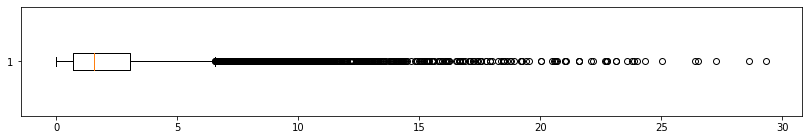

In [8]:
print(len(expected))
print(len(predicted))

# abs difference
difference = abs((expected - predicted))
print('Mean Absolute Error = ', np.mean(difference))

# show boxplot
plt.figure(figsize = (14,2))
plt.boxplot(difference, vert= False);
plt.show()